In [3]:
# import required libraries
import numpy as np
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input, Dense, Flatten, concatenate, Dropout
from keras.callbacks import EarlyStopping
from keras.datasets import mnist
from keras.applications import VGG16, ResNet50, InceptionV3
from sklearn.metrics import classification_report,confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import MaxPooling2D, BatchNormalization, Conv2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, Rescaling
from tensorflow.keras import Input 
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
from zipfile import ZipFile
file_name = "/content/drive/MyDrive/Cell.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  #print('Done')

extracted_file_path = "/content/drive/MyDrive/Cell" 

In [8]:
# Defining Image Data Gen
WIDTH = 130
HEIGHT = 130 
BATCH_SIZE = 32
train_datagen = ImageDataGenerator(rotation_range=20,
                              width_shift_range=0.1,
                              height_shift_range=0.1,
                              rescale=1/225,
                              shear_range=0.1,
                              zoom_range=0.1,
                              horizontal_flip=True,
                              fill_mode='nearest',
                              validation_split=0.2)

In [9]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [10]:
val_data = tf.keras.preprocessing.image_dataset_from_directory(
  '/content/cell_images/cell_images',
  validation_split=0.2,
  color_mode = "grayscale",
  subset="validation",
  seed=69,
  image_size=(WIDTH, HEIGHT),
  batch_size=BATCH_SIZE)

Found 27558 files belonging to 2 classes.
Using 5511 files for validation.


In [11]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(
  '/content/cell_images/cell_images',
  validation_split=0.2,
  color_mode = "grayscale",
  subset="training",
  seed=69,
  image_size=(WIDTH, HEIGHT),
  batch_size=BATCH_SIZE)

Found 27558 files belonging to 2 classes.
Using 22047 files for training.


In [121]:
# find how many batches are in val_data
val_batches = tf.data.experimental.cardinality(val_data)
test_data = val_data.take(val_batches // 2)
val_data = val_data.skip(val_batches // 2)

In [122]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_data))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_data))

Number of validation batches: 87
Number of test batches: 86


In [123]:
class_names = train_data.class_names
print(class_names)

['Parasitized', 'Uninfected']


In [124]:
# X_train = []
# y_train = []
# for images, labels in train_data:
#     X_train.append(images)
#     y_train.append(labels)
#     if len(X_train) * BATCH_SIZE >= len(train_data):
#         break
# X_train = np.concatenate(X_train, axis=0)
# y_train = np.concatenate(y_train, axis=0)

# # Split validation dataset into X and y arrays
# X_val = []
# y_val = []
# for images, labels in val_data:
#     X_val.append(images)
#     y_val.append(labels)
#     if len(X_val) * BATCH_SIZE >= len(val_data):
#         break
# X_val = np.concatenate(X_val, axis=0)
# y_val = np.concatenate(y_val, axis=0)

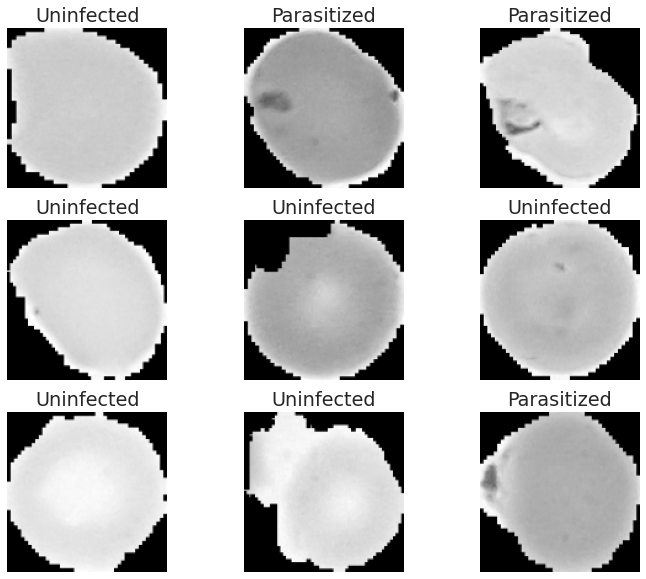

In [125]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
for images, labels in train_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"), cmap="gray")
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [126]:
# performance boosting code --> prefetching 

AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.prefetch(buffer_size=AUTOTUNE)
val_data = val_data.prefetch(buffer_size=AUTOTUNE)
test_data = test_data.prefetch(buffer_size=AUTOTUNE)

In [127]:
# applying data augmentation
data_augmentation = tf.keras.Sequential(
[
  RandomFlip('horizontal'),
  RandomRotation(0.25),
], "Augmentation_Layers")

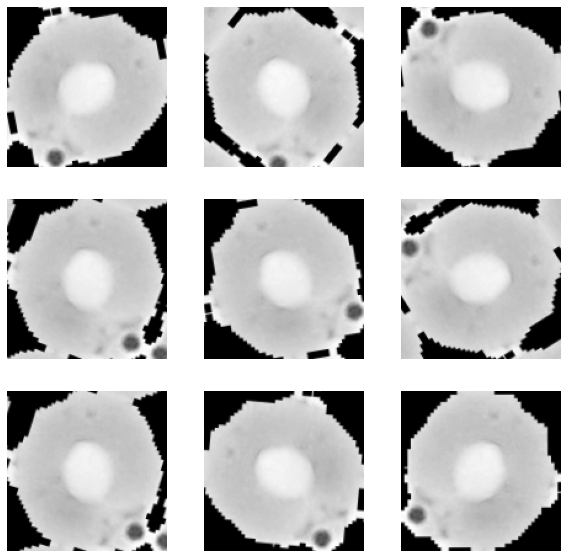

In [128]:
#seeing the effects of our data augmentation 

for image, _ in train_data.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255, cmap="gray")
    plt.axis('off')

In [129]:
# scale the inputs to between -1 to 1 
rescale = Rescaling(scale=1./127.5, offset=-1)

inputs = tf.keras.Input(shape=(WIDTH, HEIGHT, 1))
x = data_augmentation(inputs)
x = rescale(x)

x = Conv2D(128, (5, 5), activation="relu", padding="same")(x)
x = MaxPooling2D((2, 2), padding="same")(x)
x = BatchNormalization(axis=1)(x)

x = Conv2D(128, (5, 5), activation="relu", padding="same")(x)
x = MaxPooling2D((2, 2), padding="same")(x)
x = BatchNormalization(axis=1)(x)

x = Conv2D(64, (5, 5), activation="relu", padding="same")(x)
x = MaxPooling2D((2, 2), padding="same")(x)
x = BatchNormalization(axis=1)(x)

x = Conv2D(32, (5, 5), activation="relu", padding="same")(x)
x = MaxPooling2D((2, 2), padding="same")(x)
x = BatchNormalization(axis=1)(x)

x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(64, activation="relu")(x)
outputs = Dense(1, activation="sigmoid")(x)

model1 = tf.keras.Model(inputs, outputs)

In [130]:
lr = 0.001
model1.compile(optimizer=Adam(learning_rate=lr),
              loss=BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [131]:
epochs = 10
early_stop = EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)
history1 = model1.fit(train_data,
                    epochs=epochs,
                    validation_data=val_data, callbacks=[early_stop])

Epoch 1/10


/usr/local/lib/python3.9/dist-packages/keras/backend.py:5676: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


689/689 [==============================] - 119s 165ms/step - loss: 0.3766 - accuracy: 0.8205 - val_loss: 0.1606 - val_accuracy: 0.9445
Epoch 2/10
689/689 [==============================] - 113s 163ms/step - loss: 0.1699 - accuracy: 0.9424 - val_loss: 0.1524 - val_accuracy: 0.9460
Epoch 3/10
689/689 [==============================] - 112s 163ms/step - loss: 0.1533 - accuracy: 0.9475 - val_loss: 0.1280 - val_accuracy: 0.9590
Epoch 4/10
689/689 [==============================] - 113s 163ms/step - loss: 0.1449 - accuracy: 0.9492 - val_loss: 0.1415 - val_accuracy: 0.9536
Epoch 5/10
689/689 [==============================] - 114s 165ms/step - loss: 0.1394 - accuracy: 0.9507 - val_loss: 0.1249 - val_accuracy: 0.9572
Epoch 6/10
689/689 [==============================] - 114s 165ms/step - loss: 0.1374 - accuracy: 0.9528 - val_loss: 0.2085 - val_accuracy: 0.9221
Epoch 7/10
689/689 [==============================] - 114s 165ms/step - loss: 0.1354 - accuracy: 0.9536 - val_loss: 0.1173 - val_accura

In [132]:
model1.save('/content/cell_images/model1.hdf5')

In [133]:
#Model2

# scale the inputs to between -1 to 1 
rescale = Rescaling(scale=1./127.5, offset=-1)

inputs = tf.keras.Input(shape=(WIDTH, HEIGHT, 1))
x = data_augmentation(inputs)
x = rescale(x)

x = Conv2D(128, (5, 5), activation="relu", padding="same")(x)
x = MaxPooling2D((2, 2), padding="same")(x)
x = BatchNormalization(axis=1)(x)

x = Conv2D(64, (5, 5), activation="relu", padding="same")(x)
x = MaxPooling2D((2, 2), padding="same")(x)
x = BatchNormalization(axis=1)(x)

x = Conv2D(32, (5, 5), activation="relu", padding="same")(x)
x = MaxPooling2D((2, 2), padding="same")(x)
x = BatchNormalization(axis=1)(x)

x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(64, activation="relu")(x)
outputs = Dense(1, activation="sigmoid")(x)

model2 = tf.keras.Model(inputs, outputs)

In [134]:
lr = 0.001
model2.compile(optimizer=Adam(learning_rate=lr),
              loss=BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [135]:
epochs = 10
early_stop = EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)
history2 =   model2.fit(train_data,
                    epochs=epochs,
                    validation_data=val_data, callbacks=[early_stop])

Epoch 1/10


689/689 [==============================] - 111s 155ms/step - loss: 0.5705 - accuracy: 0.6999 - val_loss: 0.4853 - val_accuracy: 0.7677
Epoch 2/10
689/689 [==============================] - 105s 153ms/step - loss: 0.1856 - accuracy: 0.9367 - val_loss: 0.1471 - val_accuracy: 0.9493
Epoch 3/10
689/689 [==============================] - 107s 154ms/step - loss: 0.1659 - accuracy: 0.9438 - val_loss: 0.1348 - val_accuracy: 0.9547
Epoch 4/10
689/689 [==============================] - 106s 153ms/step - loss: 0.1540 - accuracy: 0.9474 - val_loss: 0.1609 - val_accuracy: 0.9547
Epoch 5/10
689/689 [==============================] - 106s 154ms/step - loss: 0.1505 - accuracy: 0.9487 - val_loss: 0.1392 - val_accuracy: 0.9518
Epoch 6/10
689/689 [==============================] - 104s 151ms/step - loss: 0.1463 - accuracy: 0.9490 - val_loss: 0.2025 - val_accuracy: 0.9431


In [136]:
model2.save('/content/cell_images/model2.hdf5')

In [137]:
#Model3

# scale the inputs to between -1 to 1 
rescale = Rescaling(scale=1./127.5, offset=-1)

inputs = tf.keras.Input(shape=(WIDTH, HEIGHT, 1))
x = data_augmentation(inputs)
x = rescale(x)

x = Conv2D(128, (5, 5), activation="relu", padding="same")(x)
x = MaxPooling2D((2, 2), padding="same")(x)
x = BatchNormalization(axis=1)(x)

x = Conv2D(32, (5, 5), activation="relu", padding="same")(x)
x = MaxPooling2D((2, 2), padding="same")(x)
x = BatchNormalization(axis=1)(x)

x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(64, activation="relu")(x)
outputs = Dense(1, activation="sigmoid")(x)

model3 = tf.keras.Model(inputs, outputs)

In [138]:
lr = 0.001
model3.compile(optimizer=Adam(learning_rate=lr),
              loss=BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs = 10
early_stop = EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)
history3 =   model3.fit(train_data,
                    epochs=epochs,
                    validation_data=val_data, callbacks=[early_stop])

Epoch 1/10


689/689 [==============================] - 109s 153ms/step - loss: 0.7272 - accuracy: 0.5063 - val_loss: 0.7002 - val_accuracy: 0.5814
Epoch 2/10
689/689 [==============================] - 103s 149ms/step - loss: 0.6521 - accuracy: 0.6438 - val_loss: 0.6187 - val_accuracy: 0.6901
Epoch 3/10
689/689 [==============================] - 103s 149ms/step - loss: 0.6136 - accuracy: 0.6794 - val_loss: 0.5306 - val_accuracy: 0.7731
Epoch 4/10
689/689 [==============================] - 101s 147ms/step - loss: 0.5002 - accuracy: 0.7789 - val_loss: 0.4663 - val_accuracy: 0.8043
Epoch 5/10
689/689 [==============================] - 103s 149ms/step - loss: 0.3399 - accuracy: 0.8629 - val_loss: 0.2651 - val_accuracy: 0.8982
Epoch 6/10
689/689 [==============================] - 102s 148ms/step - loss: 0.2336 - accuracy: 0.9153 - val_loss: 0.1929 - val_accuracy: 0.9369
Epoch 7/10
689/689 [==============================] - 102s 147ms/step - loss: 0.1929 - accuracy: 0.9320 - val_loss: 0.1707 - val_accura

In [1]:
model3.save('/content/cell_images/model3.hdf5')

NameError: ignored

In [12]:
### Model average / sum Ensemble
# Simple sum of all outputs / predictions and argmax across all classes
########
from keras.models import load_model
from sklearn.metrics import accuracy_score

model1 = load_model('/content/cell_images/model1.hdf5')
model2 = load_model('/content/cell_images/model2.hdf5')
model3 = load_model('/content/cell_images/model3.hdf5')

OSError: ignored

In [ ]:
# get X and Y for training data
X_train = train_data.map(lambda x, y: x)
Y_train = train_data.map(lambda x, y: y)
y_test = test_data.map(lambda x, y: y)

# get X and Y for validation data
X_val = val_data.map(lambda x, y: x)
Y_val = val_data.map(lambda x, y: y)

In [ ]:
models = [model1, model2, model3]

preds = [model.predict(test_data) for model in models]
preds=np.array(preds)
summed = np.sum(preds, axis=0)

In [ ]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report  
results = confusion_matrix 
print ('Confusion Matrix :')
print(results) 
print ('Accuracy Score :',history1.history['accuracy'] )
print ('Report : ')
print (history1.history['val_accuracy']) 

In [ ]:
# get probability predictions for each model
prediction1 = np.argmax(model1.predict(test_data), axis=1)
prediction2 = np.argmax(model2.predict(test_data), axis=1)
prediction3 = np.argmax(model3.predict(test_data), axis=1)

In [ ]:
#Weighted average ensemble
models = [model1, model2, model3]
preds = [model.predict(test_data) for model in models]
preds=np.array(preds)
weights = [0.4, 0.2, 0.4]

In [ ]:
#Use tensordot to sum the products of all elements over specified axes.
weighted_preds = np.tensordot(preds, weights, axes=((0),(0)))
weighted_ensemble_prediction = np.argmax(weighted_preds, axis=1)

In [ ]:
import itertools

def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
# Make predictions on the test data
y_pred = model1.predict(test_data)
y_pred = np.round(y_pred).flatten()

# Obtain the true labels for the test data
y_true = np.concatenate([y for x, y in test_data], axis=0)
y_true = y_true.flatten()

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)
print(cm)


In [ ]:
weighted_accuracy = accuracy_score(y_true, weighted_ensemble_prediction)

In [ ]:
accuracy1 = accuracy_score(y_true, prediction1)
accuracy2 = accuracy_score(y_true, prediction2)
accuracy3 = accuracy_score(y_true, prediction3)
ensemble_accuracy = accuracy_score(y_true, ensemble_prediction)

print('Accuracy Score for model1 = ', accuracy1)
print('Accuracy Score for model2 = ', accuracy2)
print('Accuracy Score for model3 = ', accuracy3)
print('Accuracy Score for average ensemble = ', ensemble_accuracy)


In [ ]:
print('Accuracy Score for model1 = ', accuracy1)
print('Accuracy Score for model2 = ', accuracy2)
print('Accuracy Score for model3 = ', accuracy3)
print('Accuracy Score for average ensemble = ', ensemble_accuracy)
print('Accuracy Score for weighted average ensemble = ', weighted_accuracy)

In [ ]:
#Weighted average ensemble
models = [model1, model2, model3]
preds = [model.predict(test_data) for model in models]
preds=np.array(preds)
weights = [0.4, 0.2, 0.4]

#Use tensordot to sum the products of all elements over specified axes.
weighted_preds = np.tensordot(preds, weights, axes=((0),(0)))
weighted_ensemble_prediction = np.argmax(weighted_preds, axis=1)

weighted_accuracy = accuracy_score(y_true, weighted_ensemble_prediction)

print('Accuracy Score for model1 = ', accuracy1)
print('Accuracy Score for model2 = ', accuracy2)
print('Accuracy Score for model3 = ', accuracy3)
print('Accuracy Score for average ensemble = ', ensemble_accuracy)
print('Accuracy Score for weighted average ensemble = ', weighted_accuracy)


In [ ]:
#Grid search for the best combination of w1, w2, w3 that gives maximum acuracy
models = [model1, model2, model3]
preds1 = [model.predict(test_data) for model in models]
preds1=np.array(preds1)

import pandas as pd
df = pd.DataFrame([])

for w1 in range(0, 5):
    for w2 in range(0,5):
        for w3 in range(0,5):
            wts = [w1/10.,w2/10.,w3/10.]
            wted_preds1 = np.tensordot(preds1, wts, axes=((0),(0)))
            wted_ensemble_pred = np.argmax(wted_preds1, axis=1)
            weighted_accuracy = accuracy_score(y_true, wted_ensemble_pred)
            df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1], 
                                         'wt3':wts[2], 'acc':weighted_accuracy*100}, index=[0]), ignore_index=True)
            
max_acc_row = df.iloc[df['acc'].idxmax()]
print("Max accuracy of ", max_acc_row[0], " obained with w1=", max_acc_row[1],
      " w2=", max_acc_row[2], " and w3=", max_acc_row[3])         



In [ ]:
### Explore metrics for the ideal weighted ensemble model. 

models = [model1, model2, model3]
preds = [model.predict(test_data) for model in models]
preds=np.array(preds)
ideal_weights = [0.4, 0.1, 0.2] 

#Use tensordot to sum the products of all elements over specified axes.
ideal_weighted_preds = np.tensordot(preds, ideal_weights, axes=((0),(0)))
ideal_weighted_ensemble_prediction = np.argmax(ideal_weighted_preds, axis=1)

ideal_weighted_accuracy = accuracy_score(y_true, ideal_weighted_ensemble_prediction)